<a href="https://colab.research.google.com/github/sidijju/FastMRI/blob/master/FastMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast MRI

Scientific Research into speeding up the acquisition of MRI images via training a GAN on recovered k-space images.

### Import Required Libraries

In [24]:
!pip install dicom
!pip install tensorflow

import tensorflow as tf
import numpy as np
import dicom
import os
import numpy
import matplotlib.pyplot as plt

### Retrieve Data

OASIS Data is stored in private Github repository for data privacy purposes. Running this notebook without the proper username and password will fail due to improper access. This notebook is thus just for educational purposes and cannot be run without explicit access to OASIS.

In [25]:
from getpass import getpass

user = getpass('BitBucket user')
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

!git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/OASIS-Data.git
os.chdir("OASIS-Data")

BitBucket user··········
BitBucket password··········
Cloning into 'OASIS-Data'...
remote: Counting objects: 119, done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 119 (delta 28), reused 119 (delta 28)
Receiving objects: 100% (119/119), 189.42 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (102/102), done.


In [27]:
FLAIR_DCM = []
ROI_DCM = []
T1_DCM = []
T2_DCM = []

root = "/content/OASIS-Data/BRAINIX/DICOM/"

for dirName, subdirList, fileList in os.walk("/content/OASIS-Data/BRAINIX/DICOM"):
  if(dirName == root + "FLAIR"):
    for filename in fileList:
      FLAIR_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "ROI"):
    for filename in fileList:
      ROI_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T1"):
    for filename in fileList:
      T1_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T2"):
    for filename in fileList:
      T2_DCM.append(os.path.join(dirName,filename))

/content/OASIS-Data/BRAINIX/DICOM
/content/OASIS-Data/BRAINIX/DICOM/FLAIR
/content/OASIS-Data/BRAINIX/DICOM/T2
/content/OASIS-Data/BRAINIX/DICOM/T1
/content/OASIS-Data/BRAINIX/DICOM/ROI


### Read Images


In [0]:
def getInfo(refFile):
  # Get ref file
  RefDs = dicom.read_file(refFile)

  # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
  ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(filesDCM))

  # Load spacing values (in mm)
  ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

  #calculate axes
  x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
  y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
  z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
  
  return RefDs, ConstPixelDims, ConstPixelSpacing, x, y, z

def storeList(directory, array):
  for filenameDCM in directory:
    ds = dicom.read_file(filenameDCM)
    array[:, :, directory.index(filenameDCM)] = ds.pixel_array

FLAIR_Ref = getInfo(FLAIR_DCM[0])
FLAIR_Dicom = numpy.zeros(FLAIR_Ref[1], dtype=FLAIR_Ref[0].pixel_array.dtype)
storeList(FLAIR_DCM, FLAIR_Dicom)

ROI_Ref = getInfo(ROI_DCM[0])
ROI_Dicom = numpy.zeros(ROI_Ref[1], dtype=ROI_Ref[0].pixel_array.dtype)
storeList(ROI_DCM, ROI_Dicom)

T1_Ref = getInfo(T1_DCM[0])
T1_Dicom = numpy.zeros(T1_Ref[1], dtype=T1_Ref[0].pixel_array.dtype)
storeList(T1_DCM, T1_Dicom)

T2_Ref = getInfo(T2_DCM[0])
T2_Dicom = numpy.zeros(T2_Ref[1], dtype=T2_Ref[0].pixel_array.dtype)
storeList(T2_DCM, T2_Dicom)

In [0]:
def plotPictureArr(index, arr, ref, title):
  plt.axes(label = title).set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)
  
def plotPicture(im, ref, title):
  plt.figure(dpi=50)
  plt.axes().set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)

  
def plotPictureSubplot(index, arr, ref, title, ax):
  #plt.axes(label = title).set_aspect('equal', 'datalim')
  #plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  ax.set_title(title)
  ax.set_aspect('equal', 'datalim')
  ax.pcolormesh(ref[3], ref[4], im)

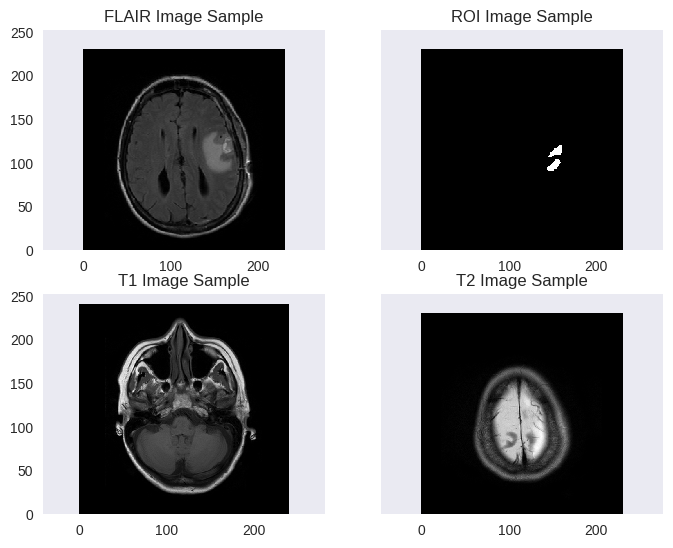

In [108]:
fig, axes = plt.subplots(2, 2, sharey = True)

fig.dpi = 100

plt.subplots_adjust(bottom = 0.0000001)

plotPictureSubplot(0, FLAIR_Dicom, FLAIR_Ref, "FLAIR Image Sample", axes[0,0])

plotPictureSubplot(0, ROI_Dicom, ROI_Ref, "ROI Image Sample", axes[0,1])

plotPictureSubplot(0, T1_Dicom, T1_Ref, "T1 Image Sample", axes[1,0])

plotPictureSubplot(0, T2_Dicom, T2_Ref, "T2 Image Sample", axes[1,1])

plt.show()
